<a href="https://colab.research.google.com/github/catSushiRoll/BSProjek/blob/main/MaLeBSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mentahan

In [1]:
from google.colab import drive
# When you run this cell, a prompt will appear asking you to authorize Google Drive access.
# Click the link, select your Google account, and allow the necessary permissions.
# Then, copy the authorization code provided and paste it back into the input box in Colab.
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
import numpy as np
import pandas as pd

def read_signal_from_txt(file_path):
    with open(file_path, 'r') as f:
        data = f.readlines()
    data = [float(line.strip()) for line in data]
    return data

def load_dataset_from_folder(folder_path, label):
    rows = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            signal = read_signal_from_txt(file_path)
            # Adjust the expected signal length if needed based on your actual data
            if len(signal) == 4097 or len(signal) == 4098: # Added 4097 as a possibility based on later code cell
                # Only append if the signal is not empty
                if signal:
                    rows.append([label] + signal)
                else:
                    print(f"Warning: File {filename} is empty or contains no valid float data.")
    return rows


# Ganti path ke lokasi dataset kamu
base_path = "/content/drive/MyDrive/dataset eeg"

# Folder-folder kategori EEG
categories = {
    'Z': 0,  # non-epileptic
    'O': 0,
    'N': 0,
    'F': 0,
    'S': 1   # epileptic
}

all_data = []

for folder, label in categories.items():
    folder_path = os.path.join(base_path, folder)
    # Check if the folder exists before trying to list its contents
    if os.path.isdir(folder_path):
        data = load_dataset_from_folder(folder_path, label)
        all_data.extend(data)
    else:
        print(f"Warning: Directory not found: {folder_path}")


# Simpan ke CSV
df = pd.DataFrame(all_data)

# Check if the dataframe is empty before saving
if not df.empty:
    # Corrected output_path to include a filename
    output_path = os.path.join('/content/drive/MyDrive/dataset eeg', 'EEG_epilepsy_dataset.csv')
    # Determine the correct number of columns for the header
    # It should be 1 for the label + the number of columns in the data part
    num_data_cols = df.shape[1] - 1 if df.shape[1] > 0 else 0
    header = ["label"] + [f"v{i}" for i in range(1, num_data_cols + 1)]

    # Ensure the header matches the number of columns in the DataFrame
    if len(header) == df.shape[1]:
        df.to_csv(output_path, index=False, header=header)
        print(f"Konversi selesai. Dataset disimpan di {output_path}")
    else:
         print(f"Error: Header length ({len(header)}) does not match DataFrame columns ({df.shape[1]}). Cannot save CSV.")

else:
    print("No data was loaded from the specified folders. CSV not saved.")

Konversi selesai. Dataset disimpan di /content/drive/MyDrive/dataset eeg/EEG_epilepsy_dataset.csv


In [10]:
%pip install tensorflow

In [ ]:
import scipy.io
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load Data from All 5 Sets
# -------------------------------

def load_data_from_mat(file_path, label):
    mat = scipy.io.loadmat(file_path)
    data = mat['data']  # Data assumed to be under 'data' key
    return data, np.full((data.shape[0],), label)

# Path to directory containing the 5 .mat files
data_dir = '/content/drive/MyDrive/dataset eeg'  # Ubah sesuai direktori kamu

# File names (gunakan nama file asli seperti "Z.mat", "O.mat", dst.)
file_labels = {
    'Z.mat': 0,  # non-seizure
    'O.mat': 0,
    'N.mat': 0,
    'F.mat': 0,
    'S.mat': 1   # seizure
}

X, y = [], []

for fname, label in file_labels.items():
    data, labels = load_data_from_mat(os.path.join(data_dir, fname), label)
    X.append(data)
    y.append(labels)

X = np.vstack(X)
y = np.hstack(y)

print("Data shape:", X.shape)  # (500, 4097)
print("Labels shape:", y.shape)

# -------------------------------
# 2. Preprocessing
# -------------------------------

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape untuk CNN input [samples, time steps, channels]
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# -------------------------------
# 3. Build CNN Model
# -------------------------------

model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(4097, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -------------------------------
# 4. Train Model
# -------------------------------

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# -------------------------------
# 5. Evaluate Model
# -------------------------------

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# -------------------------------
# 6. Visualisasi
# -------------------------------

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7656 - loss: 0.5144 - val_accuracy: 0.9062 - val_loss: 0.3553
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9440 - loss: 0.2246 - val_accuracy: 0.9375 - val_loss: 0.1470
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9826 - loss: 0.0615 - val_accuracy: 0.9062 - val_loss: 0.2702
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9876 - loss: 0.0296 - val_accuracy: 0.9688 - val_loss: 0.0780
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9952 - loss: 0.0217 - val_accuracy: 0.9375 - val_loss: 0.2288
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9911 - loss: 0.0248 - val_accuracy: 0.9375 - val_loss: 0.3956
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9866 - loss: 0.0338 - val_accuracy: 0.9375 - val_loss: 0.2756
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.9375 -

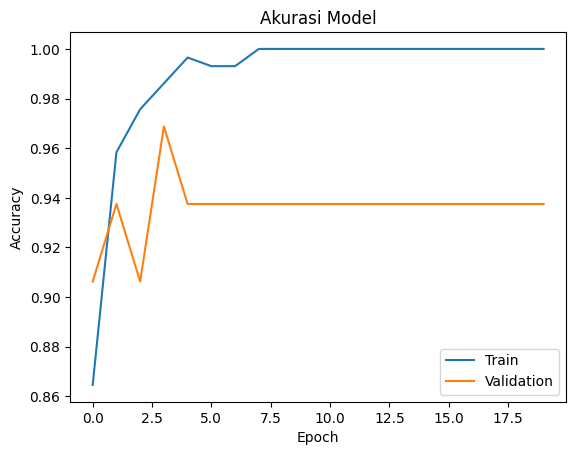

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Baca file CSV yang sudah kamu buat
df = pd.read_csv("/content/drive/MyDrive/dataset eeg/EEG_epilepsy_dataset.csv")

# Pisahkan fitur dan label
X = df.drop('label', axis=1).values  # shape: (200, 4097)
y = df['label'].values               # shape: (200,)

# Normalisasi: skala ke rentang 0-1
X = X / np.max(np.abs(X))

# Ubah input jadi [samples, time steps, channels] → CNN 1D
X = X.reshape((X.shape[0], X.shape[1], 1))

# Kalau klasifikasi 2 kelas, ini tidak wajib dikategorikan, tapi bisa pakai:
# y = to_categorical(y)  # jika ingin model output 2 neuron dan softmax

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = Sequential()
model.add(Conv1D(32, kernel_size=7, activation='relu', input_shape=(4097, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # karena binary classification


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)

loss, acc = model.evaluate(X_test, y_test)
print(f"Akurasi pada data uji: {acc:.2f}")


plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()